In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sts
import pickle

In [2]:
execfile('Stimulus.py')

In [3]:
data_folder = "Data/"

stim_file = "Stiminfo_PVCre_2021_0012_s06_e14.csv"
stim = pd.read_csv(data_folder+stim_file)

spike_times_file = "Spiketimes_PVCre_2021_0012_s06_e14.npy"
spike_times = np.load(data_folder+spike_times_file, allow_pickle=True)
active = [len(spike_times[i]) > 0 for i in range(len(spike_times))]
spike_times = spike_times[np.where(active)]

num_unit = len(spike_times)
num_trial = len(stim)

# sort by firing rate

num_spike = list(map(len, spike_times))
# num_spike = np.array([len(spike_times[i]) for i in range(len(spike_times))])
spike_times = spike_times[np.argsort(num_spike)[::-1]]

In [4]:
execfile('load.py')

stim_data.pkl
dict_keys(['stim_val', 'trial_stim_id', 'key_list', 'num_trial', 'trial_pair_id', 'pair_val', 'pair_trial_id', 'stim_id_trial', 'num_stim'])
spike_data.pkl
dict_keys(['spike_count_rate', 'avg_firing_rate', 'sem_firing_rate', 'firing_rate', 'stim_num_trial', 'C_r_fphi_theta', 'theta_hist', 'phase_hist', 'pair_hist'])
corr_data.pkl
dict_keys(['corr_stim_unit', 'optimal_avg_firing_rate', 'stim_hist', 'stim_hist_caution'])


Spike count rate

In [24]:
spike_count_rate = np.zeros((num_unit, num_trial))
for trial_id in range(num_trial):
    t_on, t_off = stim['stim_ontime'][trial_id], stim['stim_offtime'][trial_id]
    for unit_id in range(num_unit):
        spike_count_rate[unit_id, trial_id] = np.sum((spike_times[unit_id] < t_off) & (spike_times[unit_id] > t_on))
    
    spike_count_rate[:, trial_id] /= t_off-t_on

Judging by PSTH, try counting the spikes only towards the end of each trial. Each trial is 84 ms long and we count the spikes over (50, 90) for each trial.

In [8]:
spike_count_rate = np.zeros((num_unit, num_trial))
for trial_id in range(num_trial):
    t_on, t_off = stim['stim_ontime'][trial_id]+0.050, stim['stim_offtime'][trial_id]+0.084 - 0.084
    for unit_id in range(num_unit):
        spike_count_rate[unit_id, trial_id] = np.sum((spike_times[unit_id] < t_off) & (spike_times[unit_id] > t_on))
    
    spike_count_rate[:, trial_id] /= t_off-t_on

Average firing rate

In [9]:
avg_firing_rate = {}
sem_firing_rate = {}
for key in stim_id_trial:
    avg_firing_rate[key] = np.array([np.mean(spike_count_rate[:, stim_id_trial[key][i]], axis=1) for i in range(num_stim[key])]).T
    sem_firing_rate[key] = np.array([np.std(spike_count_rate[:, stim_id_trial[key][i]], axis=1)/np.sqrt(len(stim_id_trial[key][i])) for i in range(num_stim[key])]).T

# for each stim pair, gives the population activity averaged over 50 trials (transpose)

In [10]:
# mean_firing_rate[unit_id, orientation_id, phase_id]
avg_firing_rate_pair = np.zeros((num_unit, num_stim['orientation'], num_stim['phase']))
for i in range(num_stim['pair']):
    avg_firing_rate_pair[:, i//20, i%20] = np.mean(spike_count_rate[:, stim_id_trial['pair'][i]], axis=1)

Firing rate

In [9]:
# concatenate spike times of all trials with the same stimuli
# firing rate
trial_spike_times = np.ndarray((num_unit, num_trial), dtype=object)
delta_t_on = 0.02 # 20ms
delta_t_off = 0.2
for trial_id in range(num_trial):
    t_on, t_off = stim['stim_ontime'][trial_id]-delta_t_on, stim['stim_offtime'][trial_id]+delta_t_off
    for unit_id in range(num_unit):
        trial_spike_times[unit_id, trial_id] = spike_times[unit_id][np.where((spike_times[unit_id] < t_off) & (spike_times[unit_id] > t_on))] - t_on
        

In [10]:
max_dur = max(stim['stim_offtime']-stim['stim_ontime'])

In [11]:
time_bin = 0.001 # 1ms
T = delta_t_on + delta_t_off + max_dur
time_bin_edges = np.arange(0, T+time_bin, time_bin)
num_bins = len(time_bin_edges)-1

firing_rate = {}

for key in key_list:
    firing_rate[key] = np.zeros((num_unit, num_stim[key], num_bins))
    for stim_id, trials in enumerate(stim_id_trial[key]):
        for unit_id in range(num_unit):
            cumulative_spike_times = np.concatenate(trial_spike_times[unit_id, trials])
            for t in cumulative_spike_times:
                firing_rate[key][unit_id, stim_id, int(t//time_bin)] += 1
                # firing_rate[key][unit_id, stim_id] = np.histogram(cumulative_spike_times, time_bin_edges)
    
    firing_rate[key] /= time_bin*len(trials)

In [12]:
stim_num_trial = {'pair':50, 'orientation':1000, 'phase':1000}

In [13]:
time_bin = 0.001 # 1ms
delta_t_on = 0.02 # 20ms
delta_t_off = 0.2
max_dur = max(stim['stim_offtime']-stim['stim_ontime'])

T = delta_t_on + delta_t_off + max_dur
time_bin_edges = np.arange(0, T+time_bin, time_bin)
num_bins = len(time_bin_edges) - 1

In [14]:
latest_spike_time = max([np.max(s) for s in spike_times if len(s)])
latest_stim_offtime = list(stim['stim_offtime'])[-1]
experiment_dur = max([latest_spike_time, latest_stim_offtime])

In [15]:
import ipywidgets as widgets       # interactive display

ValueError: xmin must be a single scalar value, but got g--

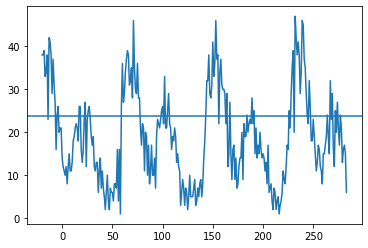

In [16]:
# PSTH

unit_id = 1
key = 'orientation'
stim_id = 4

time = (time_bin_edges[:-1] - delta_t_on)/time_bin
stim_time = np.arange(0, max_dur, time_bin)/time_bin
plt.plot(time, firing_rate[key][unit_id, stim_id])
plt.axhline(avg_firing_rate[key][unit_id, stim_id])
plt.axhline(np.mean(avg_firing_rate['pair'][unit_id]), 'g--')
plt.axhline(len(spike_times[unit_id])/experiment_dur, 'b--')

if key == 'pair':
    plt.hlines(stim_time, -1*np.ones(len(stim_time)),  'r-', label=' $\\theta = %d' %stim_val[key][stim_id][0]+'^\circ$\n $\phi = %d' %stim_val[key][stim_id][1]+'^\circ$')

else:
    plt.plot(stim_time, -1*np.ones(len(stim_time)),  'r-', label='stimulus: '+key+' = $%d' %stim_val[key][stim_id]+'^\circ$')

plt.ylabel('firing rate/Hz')
plt.xlabel('t/ms')
plt.suptitle('PSTH ' + '%d'%stim_num_trial[key] + ' trials - unit '+'%d'%unit_id)
plt.legend()
plt.show()

In [83]:
# sliding window
n = 80
kernel = np.ones(n)/n
smooth_firing_rate = {}
for key in key_list:
    smooth_firing_rate[key] = np.zeros((num_unit, num_stim[key], num_bins))
    for unit_id in range(num_unit):
        for stim_id in range(num_stim[key]):
            smooth_firing_rate[key][unit_id, stim_id] = np.convolve(firing_rate[key][unit_id, stim_id], kernel)[int(n//2):int(n//2)+num_bins]

In [84]:
max([np.max(firing_rate[key]) for key in key_list])

200.0

In [92]:
# key = 'orientation'
time = (time_bin_edges[:-1] - delta_t_on)/time_bin
stim_time = np.arange(0, max_dur, time_bin)/time_bin

# @widgets.interact(stim_id=widgets.FloatSlider(0, min=0, max=1, step=0.01),
#  key=widgets.RadioButtons(
#     options=key_list,
# #    value='pineapple', # Defaults to 'pineapple'
# #    layout={'width': 'max-content'}, # If the items' names are long
#     description='stimulus:',
#     disabled=False
# ))

@widgets.interact(key=widgets.RadioButtons(
    options=key_list,
#    value='pineapple', # Defaults to 'pineapple'
#    layout={'width': 'max-content'}, # If the items' names are long
    description='stimulus:',
    disabled=False
))

def PSTH_key(key):
    if key=='pair':
        @widgets.interact(phi=widgets.IntSlider(0, min=0, max=19), theta=widgets.IntSlider(0, min=0, max=19))
    
        def PSTH(phi, theta):
            stim_id = theta*20 + phi

            # stim_id = int(np.floor(stim_id * num_stim[key]))
            fig, ax = plt.subplots(1, 4, figsize=(5*4,1*4))
            for unit_id in range(4):
                ax[unit_id%4].plot(time, smooth_firing_rate[key][unit_id, stim_id])
                ax[unit_id%4].plot(time, avg_firing_rate[key][unit_id, stim_id] * np.ones(len(time)))
                ax[unit_id%4].plot(time, np.mean(avg_firing_rate['pair'][unit_id]) * np.ones(len(time)), 'g--')
                ax[unit_id%4].plot(time, len(spike_times[unit_id])/experiment_dur * np.ones(len(time)), 'b--')

                if key == 'pair':
                    ax[unit_id%4].plot(stim_time, -1*np.ones(len(stim_time)),  'r-', label=' $\\theta = %d' %stim_val[key][stim_id][0]+'^\circ$\n $\phi = %d' %stim_val[key][stim_id][1]+'^\circ$')

                else:
                    ax[unit_id%4].plot(stim_time, -1*np.ones(len(stim_time)),  'r-', label='stimulus: '+key+' = $%d' %stim_val[key][stim_id]+'^\circ$')

                ax[unit_id%4].set_ylabel('firing rate/Hz')
                ax[unit_id%4].set_xlabel('t/ms')
                ax[unit_id%4].set_ylim([-2,200])
                ax[unit_id%4].set_title('PSTH ' + '%d'%stim_num_trial[key] + ' trials - unit '+'%d'%unit_id)
                ax[unit_id%4].legend(loc='upper center')
            plt.show()

    else:
        @widgets.interact(stim_id=widgets.IntSlider(0, min=0, max=19))
 
        def PSTH(stim_id):

            # stim_id = int(np.floor(stim_id * num_stim[key]))
            fig, ax = plt.subplots(1, 4, figsize=(5*4,1*4))
            for unit_id in range(4):
                ax[unit_id%4].plot(time, smooth_firing_rate[key][unit_id, stim_id])
                ax[unit_id%4].plot(time, avg_firing_rate[key][unit_id, stim_id] * np.ones(len(time)))
                ax[unit_id%4].plot(time, np.mean(avg_firing_rate['pair'][unit_id]) * np.ones(len(time)), 'g--')
                ax[unit_id%4].plot(time, len(spike_times[unit_id])/experiment_dur * np.ones(len(time)), 'b--')

                if key == 'pair':
                    ax[unit_id%4].plot(stim_time, -1*np.ones(len(stim_time)),  'r-', label=' $\\theta = %d' %stim_val[key][stim_id][0]+'^\circ$\n $\phi = %d' %stim_val[key][stim_id][1]+'^\circ$')

                else:
                    ax[unit_id%4].plot(stim_time, -1*np.ones(len(stim_time)),  'r-', label='stimulus: '+key+' = $%d' %stim_val[key][stim_id]+'^\circ$')

                ax[unit_id%4].set_ylabel('firing rate/Hz')
                ax[unit_id%4].set_xlabel('t/ms')
                ax[unit_id%4].set_ylim([-2,200])
                ax[unit_id%4].set_title('PSTH ' + '%d'%stim_num_trial[key] + ' trials - unit '+'%d'%unit_id)
                ax[unit_id%4].legend(loc='upper center')
            plt.show()

interactive(children=(RadioButtons(description='stimulus:', options=('pair', 'orientation', 'phase'), value='p…

In [60]:
# key = 'orientation'
time = (time_bin_edges[:-1] - delta_t_on)/time_bin
stim_time = np.arange(0, max_dur, time_bin)/time_bin

@widgets.interact(stim_id=widgets.FloatSlider(0, min=0, max=1, step=0.01),
 key=widgets.RadioButtons(
    options=key_list,
#    value='pineapple', # Defaults to 'pineapple'
#    layout={'width': 'max-content'}, # If the items' names are long
    description='stimulus:',
    disabled=False
))

def PSTH(key, stim_id):
    stim_id = int(np.floor(stim_id * num_stim[key]))
    fig, ax = plt.subplots(10, 4, figsize=(5*4,10*4))
    for unit_id in range(num_unit):
        ax[unit_id//4, unit_id%4].plot(time, smooth_firing_rate[key][unit_id, stim_id])
        ax[unit_id//4, unit_id%4].plot(time, avg_firing_rate[key][unit_id, stim_id] * np.ones(len(time)))
        ax[unit_id//4, unit_id%4].plot(time, np.mean(avg_firing_rate['pair'][unit_id]) * np.ones(len(time)), 'g--')
        ax[unit_id//4, unit_id%4].plot(time, len(spike_times[unit_id])/experiment_dur * np.ones(len(time)), 'b--')

        if key == 'pair':
            ax[unit_id//4, unit_id%4].plot(stim_time, -1*np.ones(len(stim_time)),  'r-', label=' $\\theta = %d' %stim_val[key][stim_id][0]+'^\circ$\n $\phi = %d' %stim_val[key][stim_id][1]+'^\circ$')

        else:
            ax[unit_id//4, unit_id%4].plot(stim_time, -1*np.ones(len(stim_time)),  'r-', label='stimulus: '+key+' = $%d' %stim_val[key][stim_id]+'^\circ$')

        ax[unit_id//4, unit_id%4].set_ylabel('firing rate/Hz')
        ax[unit_id//4, unit_id%4].set_xlabel('t/ms')
        ax[unit_id//4, unit_id%4].set_ylim([-2,200])
        ax[unit_id//4, unit_id%4].set_title('PSTH ' + '%d'%stim_num_trial[key] + ' trials - unit '+'%d'%unit_id)
        ax[unit_id//4, unit_id%4].legend(loc='upper center')
    plt.show()

interactive(children=(RadioButtons(description='stimulus:', options=('pair', 'orientation', 'phase'), value='p…

Subtract average phase response

In [22]:
r_fphi = np.copy(spike_count_rate)
for stim_id, trials in enumerate(stim_id_trial['phase']):
    for unit_id in range(num_unit):
        r_fphi[unit_id, trials] -= avg_firing_rate['phase'][unit_id, stim_id]


In [23]:
r_fphi

array([[ 1.69541249e-03,  3.22163614e+01,  2.03681866e+00, ...,
         2.90363390e+00, -2.78436986e+01,  3.35952210e+01],
       [ 6.81509867e+01, -2.28685128e+01, -2.80524644e+01, ...,
        -2.65551073e+01, -2.28685128e+01, -2.37690514e+01],
       [ 1.30971358e+01, -1.61529328e+01, -1.69339763e+01, ...,
        -1.60046681e+01,  1.38770972e+01, -1.74139233e+01],
       ...,
       [-6.00600601e-02, -5.97908660e-02, -2.99401198e-02, ...,
         0.00000000e+00, -5.97908660e-02,  0.00000000e+00],
       [-3.00300300e-02,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -2.99401198e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [24]:
theta = np.copy(stim['grat_orientation'])

In [25]:
theta.shape

(20000,)

In [26]:
C_r_fphi_theta = [np.convolve(r_fphi[unit_id], theta[::-1])[::-1] for unit_id in range(num_unit)] # reverse correlation

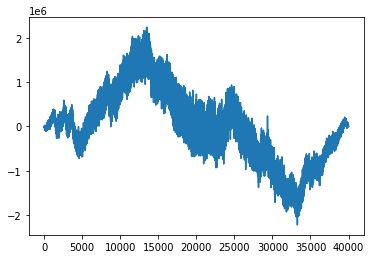

In [27]:
plt.plot(C_r_fphi_theta[0])

In [28]:
np.argmax(C_r_fphi_theta, axis=1)

array([13505, 24614, 24976, 28254, 27733, 13139, 14842, 13004, 13395,
       13337, 13460, 12405, 26205,  5522, 24844, 13343, 13603, 24607,
        5545, 27818, 24654,  4900, 12822, 23467, 32994, 24963,  4929,
       13537, 23406, 32700, 32950, 22641, 33750, 27543,  9353, 25907,
       27023, 25357, 20291, 33125], dtype=int64)

In [29]:
autocorr_theta = np.convolve(theta, theta[::-1])

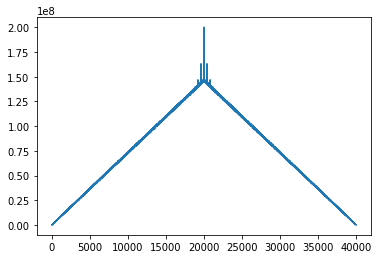

In [30]:
plt.plot(autocorr_theta)

In [31]:
temporal_kernel = np.fft.ifft(np.fft.fft(C_r_fphi_theta)/np.fft.fft(autocorr_theta))

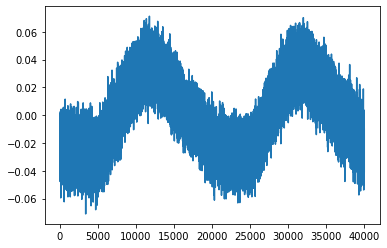

In [32]:
plt.plot(np.real(temporal_kernel[1]))

In [33]:
avg_firing_rate['phase'][0, trial_stim_id['phase']] + np.real(np.convolve(temporal_kernel[0], theta, 'valid'))

array([58.61796736, 46.68999397,  1.33161805, ..., 10.85536343,
       21.27754034, 37.21827067])

In [34]:
avg_firing_rate['phase'][0, trial_stim_id['phase']]

array([29.93842435, 27.84369865, 27.99321137, ..., 27.12639613,
       27.84369865, 26.46483905])

In [35]:
spike_count_rate[0]

array([29.94011976, 60.06006006, 30.03003003, ..., 30.03003003,
        0.        , 60.06006006])

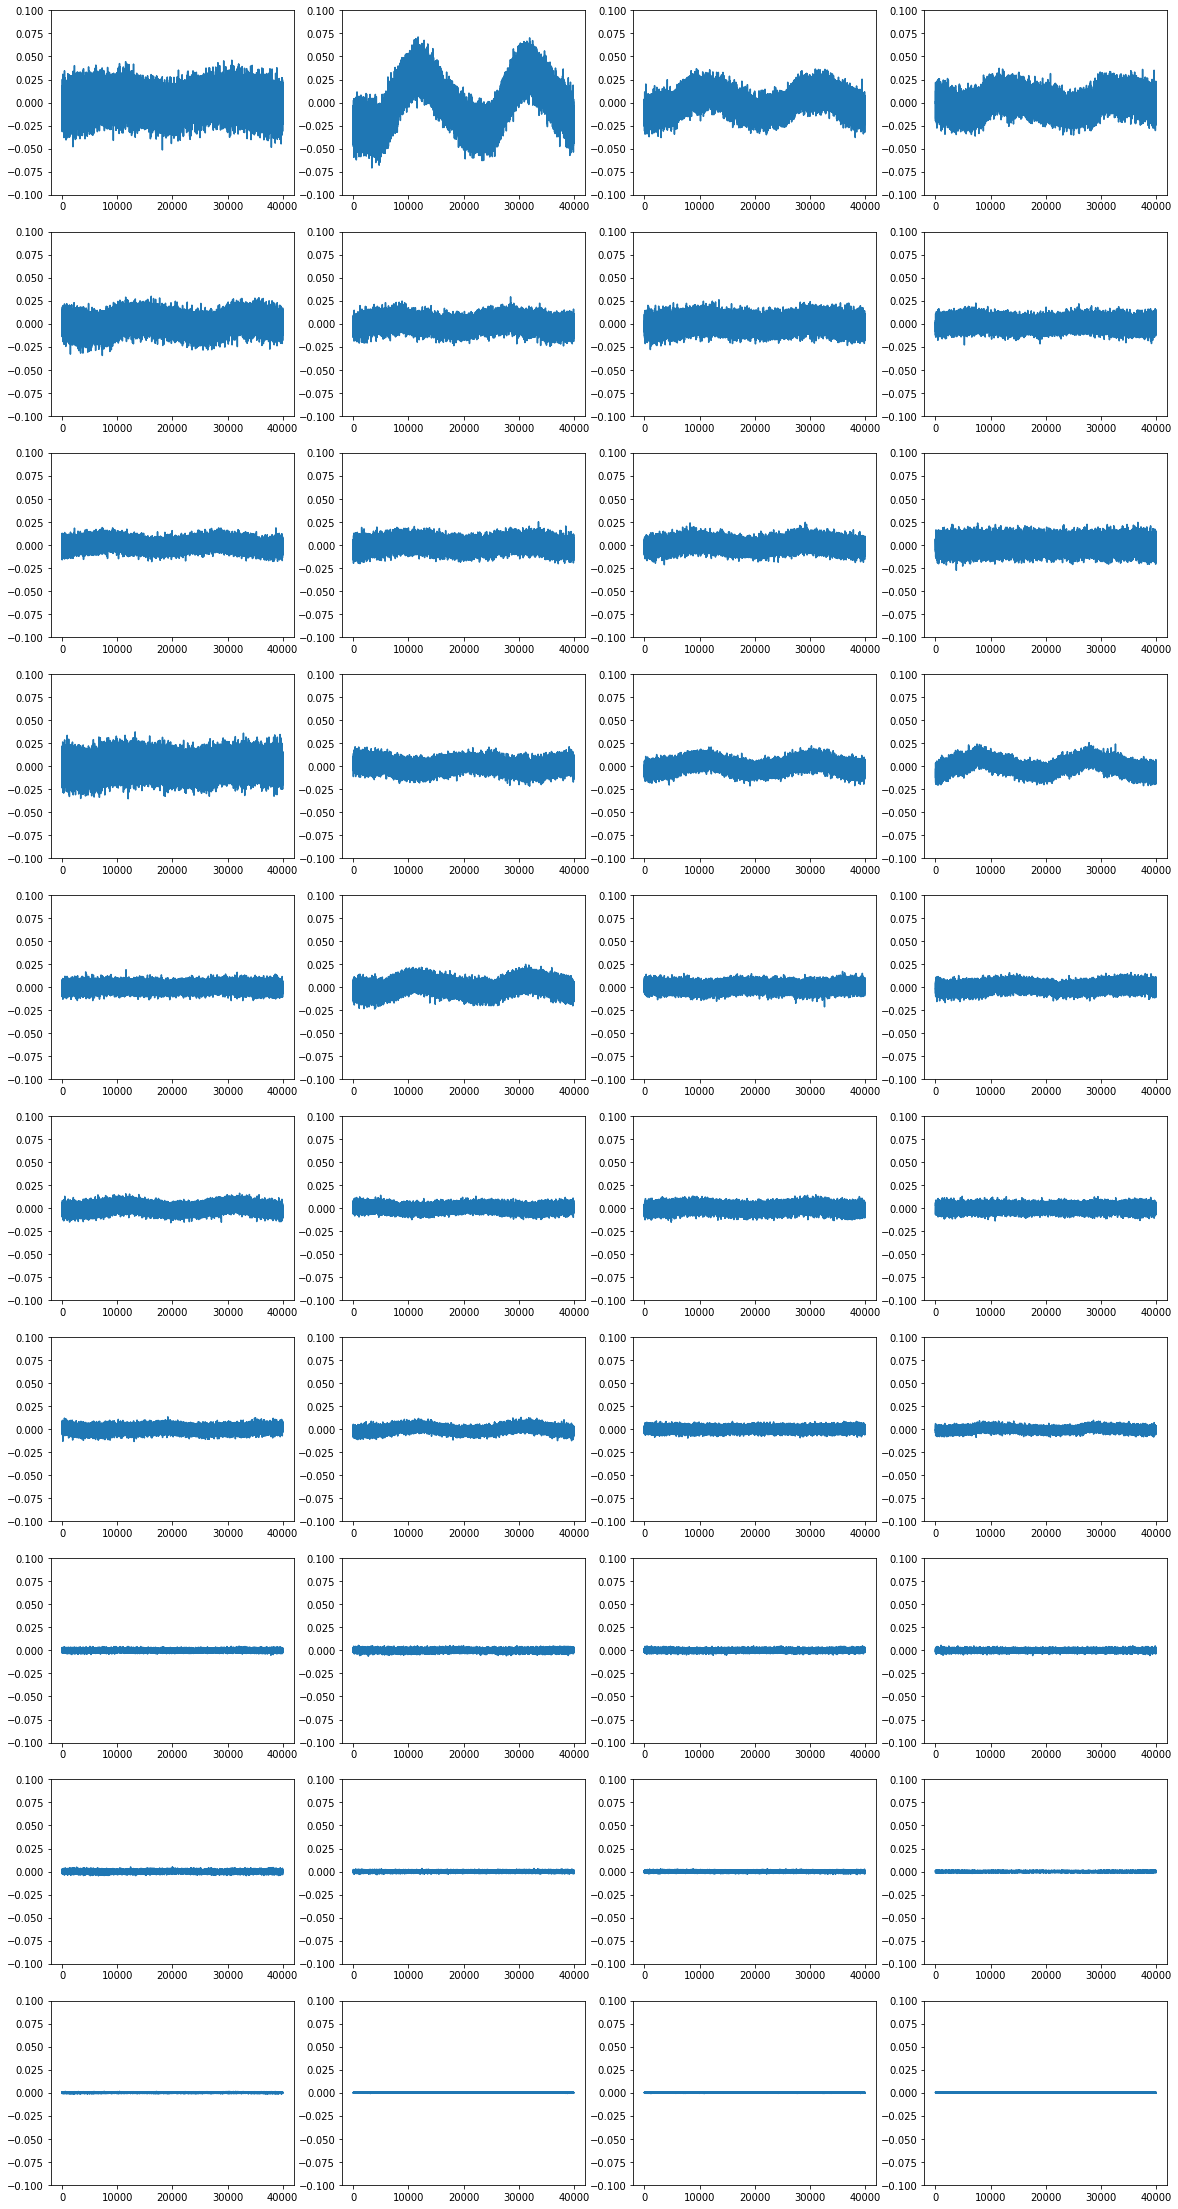

In [36]:
fig, ax = plt.subplots(10, 4, figsize=(5*4, 10*4))
for unit_id in range(40):
    ax[unit_id//4, unit_id%4].plot(np.real(temporal_kernel[unit_id]))
    # ax[unit_id//4, unit_id%4].set_ylabel('avg firing rate / Hz')
    ax[unit_id//4, unit_id%4].set_ylim([-0.1,0.1])

# ax[0,0].set_title('firing rate (Hz) vs. phase')
plt.show()

Perispike Stimulus Histogram

In [37]:
tau_bin = 0.05
tau_range = np.arange(0, 0.5+tau_bin, tau_bin)
theta_hist = np.zeros((num_unit, len(tau_range), num_stim['orientation']))
for stim_id, trials in enumerate(stim_id_trial['orientation']):
    print(stim_id, end='\r')
    for trial_id in trials:
        t_on, t_off = stim['stim_ontime'][trial_id], stim['stim_offtime'][trial_id]
        for i, tau in enumerate(tau_range):
            # how many spikes between t_on + tau and t_off + tau
            for unit_id in range(num_unit):
                theta_hist[unit_id, i, stim_id] += np.sum((spike_times[unit_id] > t_on + tau) & (spike_times[unit_id] < t_off + tau))


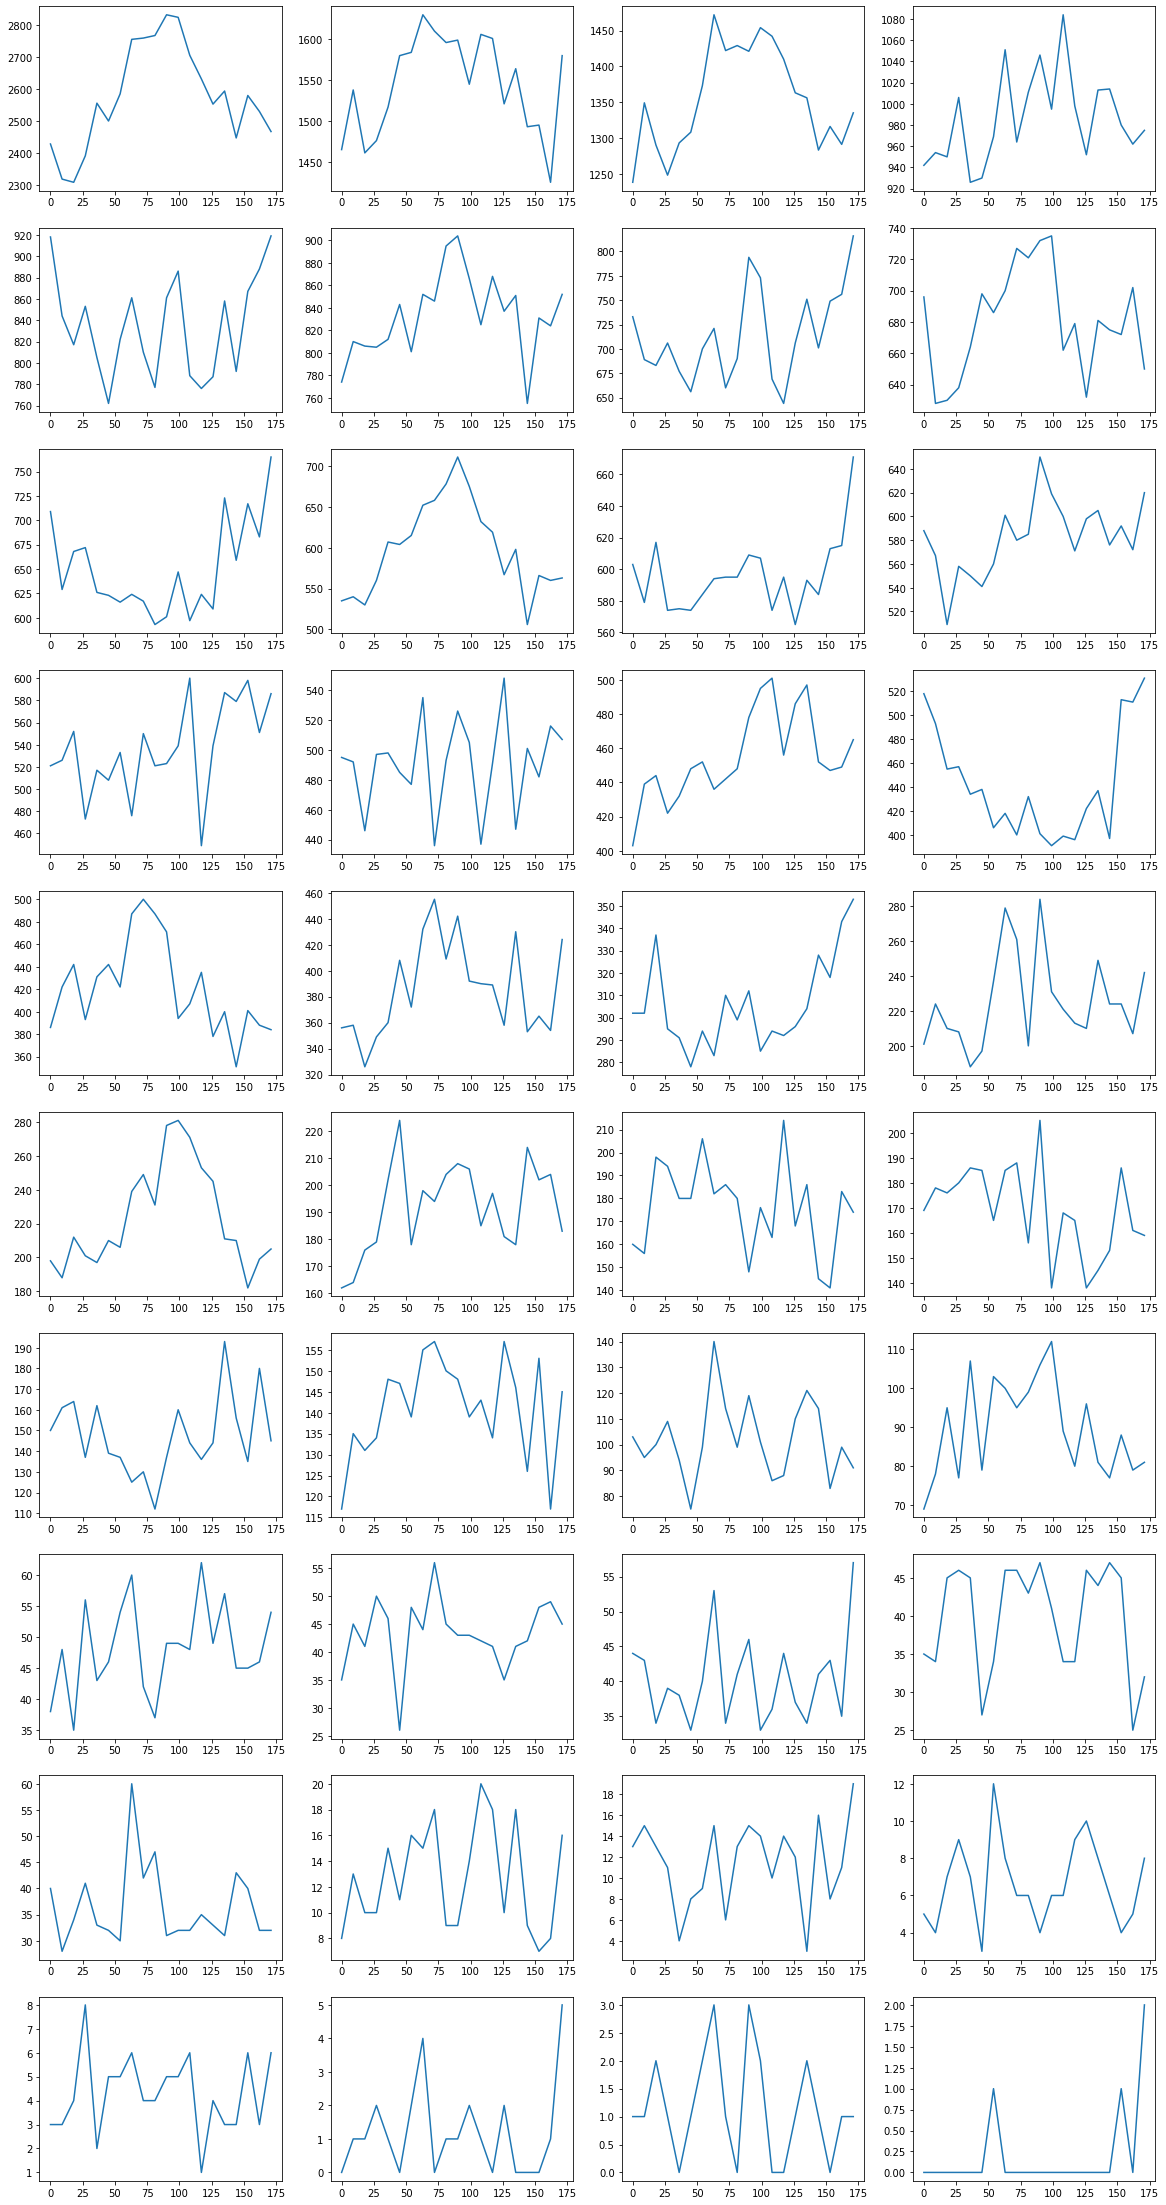

In [38]:
fig, ax = plt.subplots(10,4, figsize=(5*4, 10*4))
for unit_id in range(num_unit):
    ax[unit_id//4, unit_id%4].plot(stim_val['orientation'], theta_hist[unit_id, 1])

the range of phases should be restricted to get good orientaiton tuning curves (?)

In [39]:
delay_orientation_tuning = theta_hist / 0.084

To carry out topological data analysis, we need 400 data points (number of stimulus pairs) in the neuronal firing rate space.

In [40]:
key = 'phase'
tau_bin = 0.05
tau_range = np.arange(0, 0.5+tau_bin, tau_bin)
phase_hist = np.zeros((num_unit, len(tau_range), num_stim[key]))
for stim_id, trials in enumerate(stim_id_trial[key]):
    print(stim_id, end='\r')
    for trial_id in trials:
        t_on, t_off = stim['stim_ontime'][trial_id], stim['stim_offtime'][trial_id]
        for i, tau in enumerate(tau_range):
            # how many spikes between t_on + tau and t_off + tau
            for unit_id in range(num_unit):
                phase_hist[unit_id, i, stim_id] += np.sum((spike_times[unit_id] > t_on + tau) & (spike_times[unit_id] < t_off + tau))


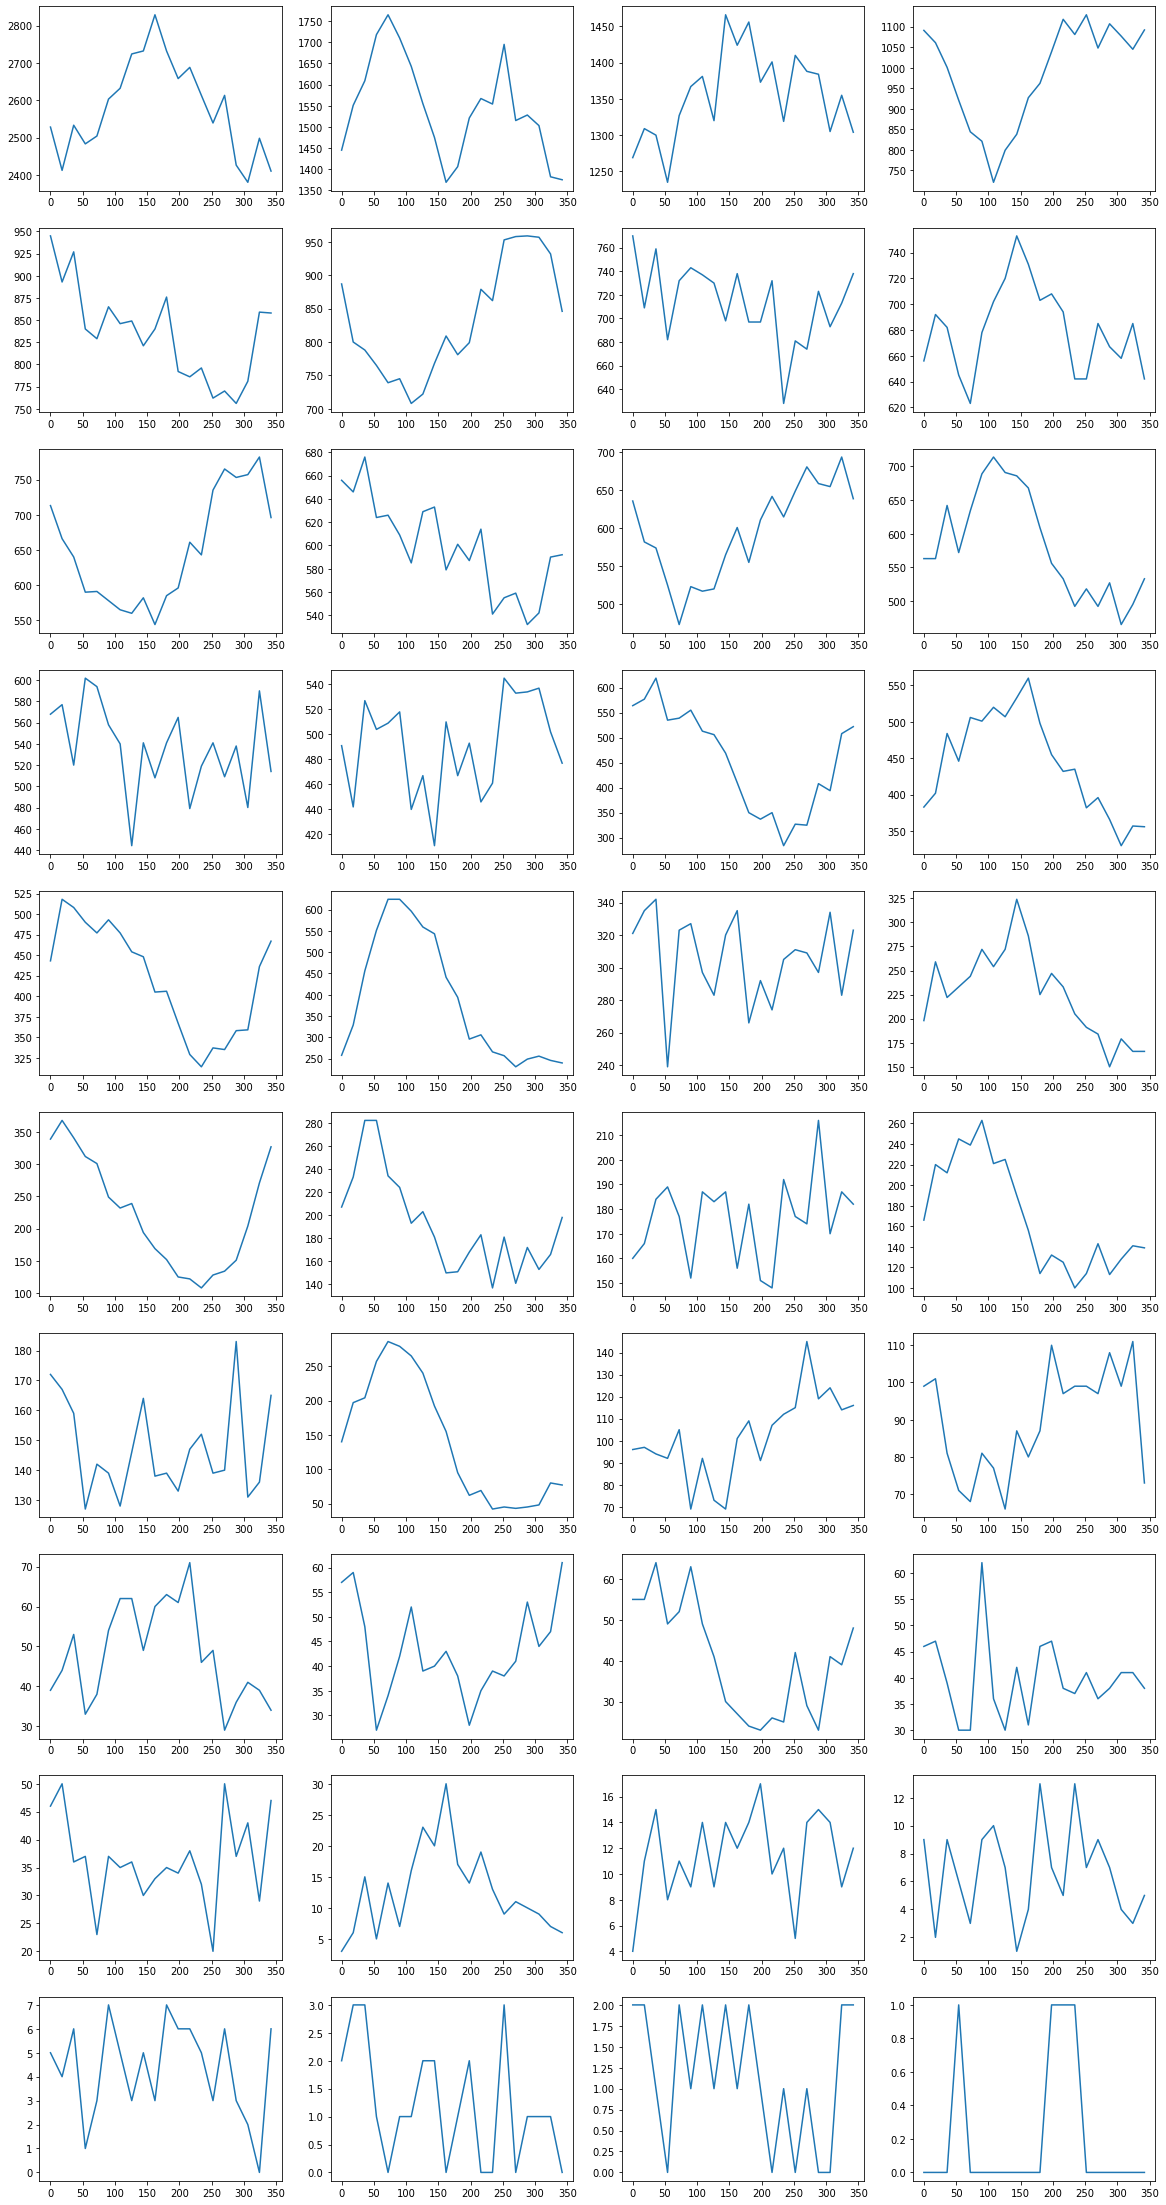

In [41]:
fig, ax = plt.subplots(10,4, figsize=(5*4, 10*4))
for unit_id in range(num_unit):
    ax[unit_id//4, unit_id%4].plot(stim_val['phase'], phase_hist[unit_id, 1])

In [42]:
key = 'pair'
tau_bin = 0.05
tau_range = np.arange(0, 0.5+tau_bin, tau_bin)
pair_hist = np.zeros((num_unit, len(tau_range), num_stim[key]))
for stim_id, trials in enumerate(stim_id_trial[key]):
    print(stim_id, end='\r')
    for trial_id in trials:
        t_on, t_off = stim['stim_ontime'][trial_id], stim['stim_offtime'][trial_id]
        for i, tau in enumerate(tau_range):
            # how many spikes between t_on + tau and t_off + tau
            for unit_id in range(num_unit):
                pair_hist[unit_id, i, stim_id] += np.sum((spike_times[unit_id] > t_on + tau) & (spike_times[unit_id] < t_off + tau))


2D Tuning

In [43]:
avg_firing_rate_pair = pair_hist.reshape((num_unit, len(tau_range), num_stim['orientation'], num_stim['phase']))

In [44]:
# normalize
import scipy.stats as sts
avg_firing_rate_pair_normalized = sts.zscore(avg_firing_rate_pair.reshape(num_unit, 20*20), axis = 1).reshape(num_unit, 20, 20)

ValueError: cannot reshape array of size 176000 into shape (40,400)

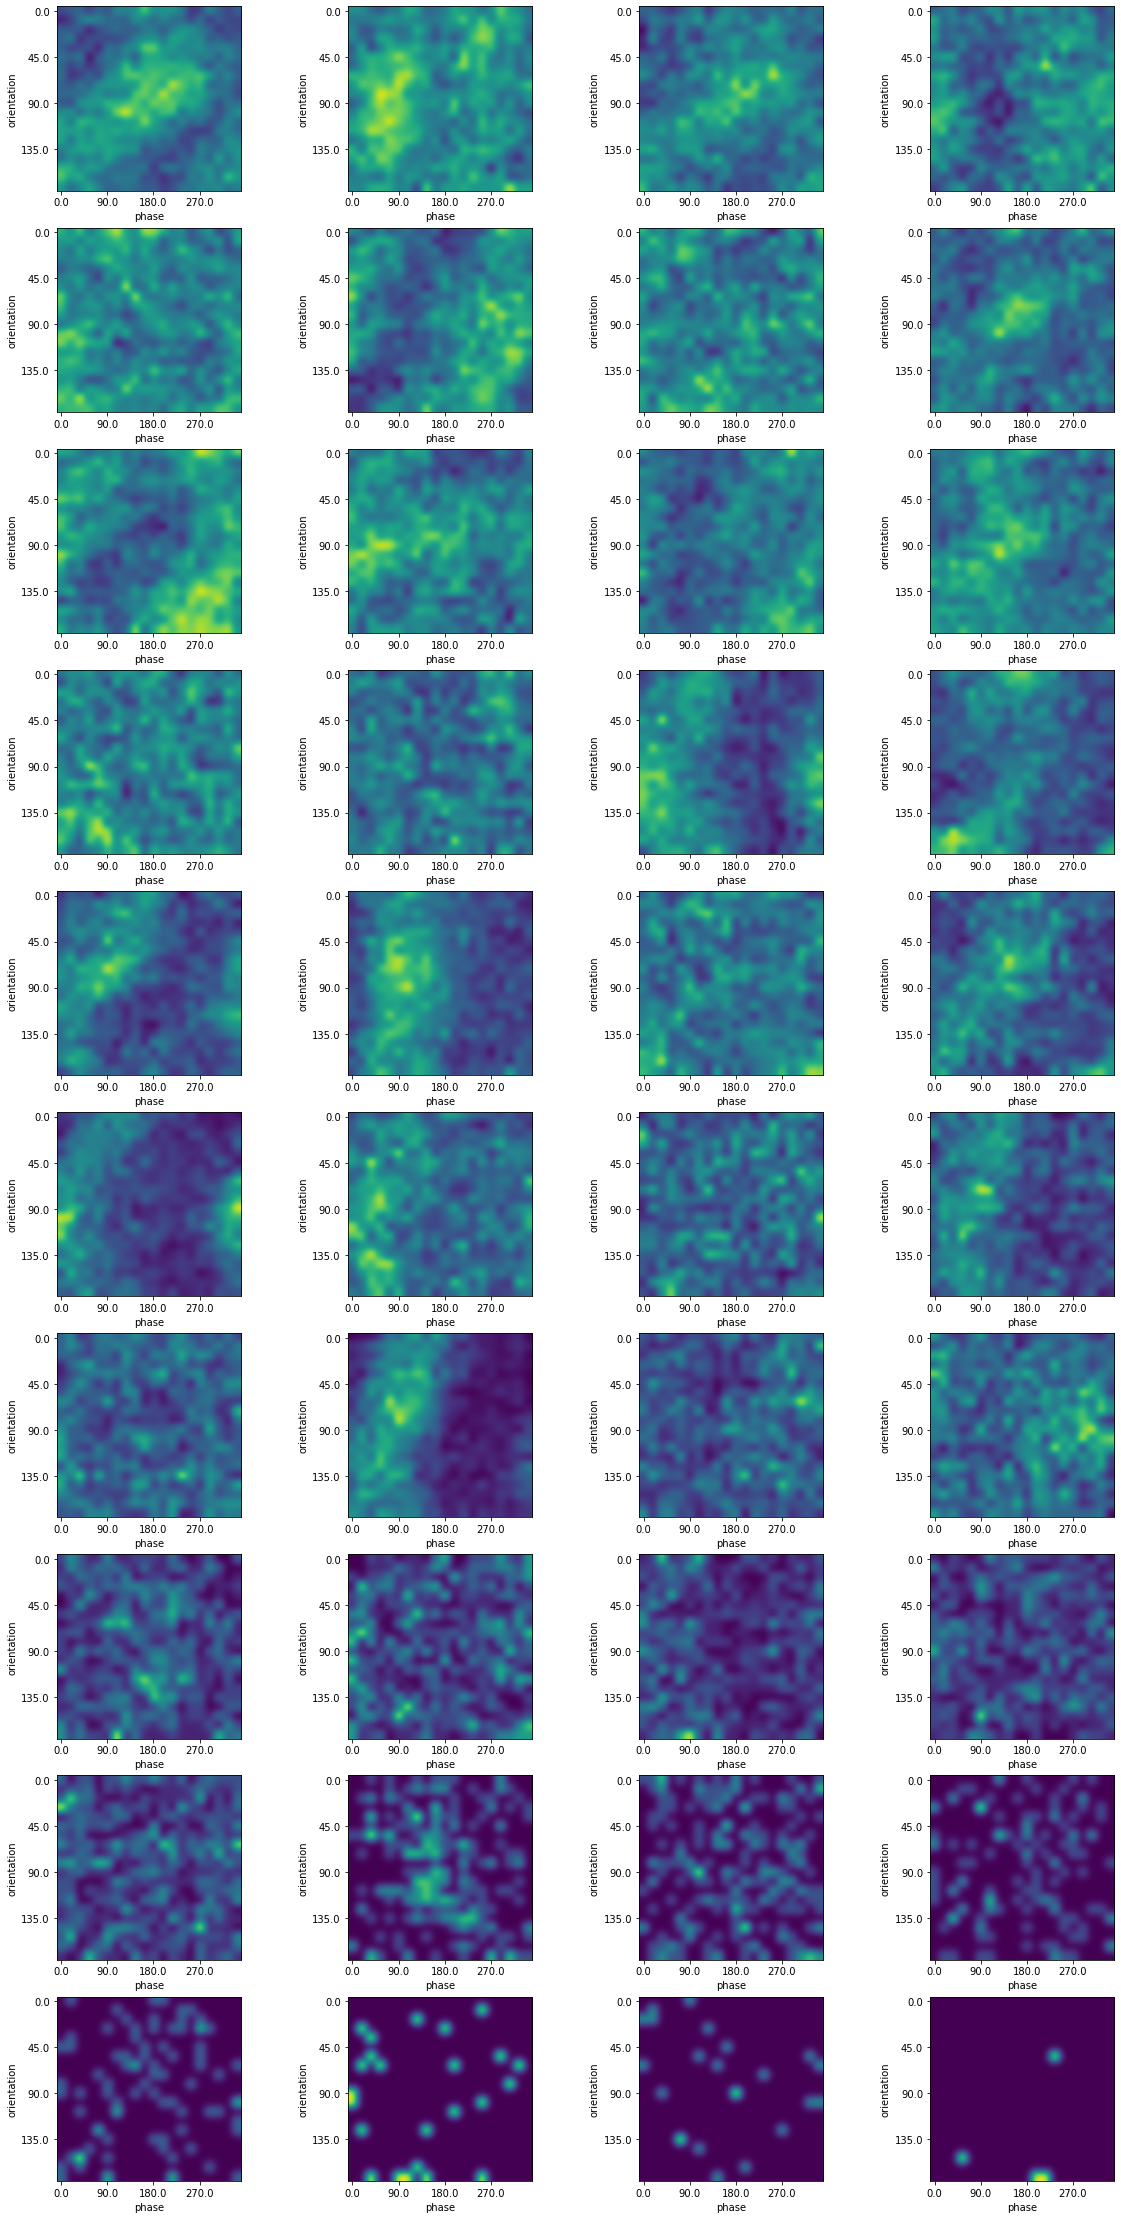

In [45]:
fig, ax = plt.subplots(10, 4, figsize=(5*4, 10*4))
for unit_id in range(40):
    ax[unit_id//4, unit_id%4].imshow(avg_firing_rate_pair[unit_id, 1], interpolation='gaussian')

    ax[unit_id//4, unit_id%4].set_xticks(np.arange(20)[::5])
    ax[unit_id//4, unit_id%4].set_xticklabels(stim_val['phase'][::5])
    ax[unit_id//4, unit_id%4].set_yticks(np.arange(20)[::5])
    ax[unit_id//4, unit_id%4].set_yticklabels(stim_val['orientation'][::5])
    ax[unit_id//4, unit_id%4].set_xlabel('phase')
    ax[unit_id//4, unit_id%4].set_ylabel('orientation')
    
plt.show()

In [46]:
# klein bottle symmetry
@widgets.interact(tau_id=widgets.IntSlider(0, min=0, max=len(tau_range)-1))

def klein_bottle(tau_id):
    fig, ax = plt.subplots(1, 4, figsize=(5*4, 1*4))
    klein_bottle_rate = np.zeros((num_unit, 40, 40))
    for unit_id in range(4):
        x = np.hstack((avg_firing_rate_pair[unit_id,tau_id], avg_firing_rate_pair[unit_id,tau_id]))
        klein_bottle_rate[unit_id] = np.vstack((x, x[:,::-1]))
        ax[unit_id%4].imshow(klein_bottle_rate[unit_id], interpolation='gaussian')
        ax[unit_id%4].plot()
        # ax[unit_id//4, unit_id%4].set_xticks(np.arange(40)[::5])
        # ax[unit_id//4, unit_id%4].set_xticklabels(np.concatenate((stim_val['phase'][::5],stim_val['phase'][::5])))
        # ax[unit_id//4, unit_id%4].set_yticks(np.arange(40)[::5])
        # ax[unit_id//4, unit_id%4].set_yticklabels(stim_val['orientation'][::5])
        ax[unit_id%4].set_xticks([])
        ax[unit_id%4].set_yticks([])
        ax[unit_id%4].plot(np.arange(40), 19.5*np.ones(40), 'r', linewidth=0.5)
        ax[unit_id%4].plot(19.5*np.ones(40), np.arange(40), 'r', linewidth=0.5)

        ax[unit_id%4].set_xlabel('phase')
        ax[unit_id%4].set_ylabel('orientation')
        
    plt.show()

interactive(children=(IntSlider(value=0, description='tau_id', max=10), Output()), _dom_classes=('widget-inter…

Klein bottle

In [47]:
# klein bottle symmetry
@widgets.interact(tau_id=widgets.IntSlider(0, min=0, max=len(tau_range)-1))

def klein_bottle(tau_id):
    fig, ax = plt.subplots(10, 4, figsize=(5*4, 10*4))
    klein_bottle_rate = np.zeros((num_unit, 40, 40))
    for unit_id in range(40):
        x = np.hstack((avg_firing_rate_pair[unit_id,tau_id], avg_firing_rate_pair[unit_id,tau_id]))
        klein_bottle_rate[unit_id] = np.vstack((x, x[:,::-1]))
        ax[unit_id//4, unit_id%4].imshow(klein_bottle_rate[unit_id], interpolation='gaussian')
        ax[unit_id//4, unit_id%4].plot()
        # ax[unit_id//4, unit_id%4].set_xticks(np.arange(40)[::5])
        # ax[unit_id//4, unit_id%4].set_xticklabels(np.concatenate((stim_val['phase'][::5],stim_val['phase'][::5])))
        # ax[unit_id//4, unit_id%4].set_yticks(np.arange(40)[::5])
        # ax[unit_id//4, unit_id%4].set_yticklabels(stim_val['orientation'][::5])
        ax[unit_id//4, unit_id%4].set_xticks([])
        ax[unit_id//4, unit_id%4].set_yticks([])
        ax[unit_id//4, unit_id%4].plot(np.arange(40), 19.5*np.ones(40), 'r', linewidth=0.5)
        ax[unit_id//4, unit_id%4].plot(19.5*np.ones(40), np.arange(40), 'r', linewidth=0.5)

        ax[unit_id//4, unit_id%4].set_xlabel('phase')
        ax[unit_id//4, unit_id%4].set_ylabel('orientation')
        
    plt.show()

interactive(children=(IntSlider(value=0, description='tau_id', max=10), Output()), _dom_classes=('widget-inter…

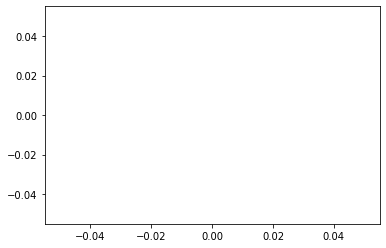

In [48]:
plt.plot()
for trial_id in range(num_trial):
    t_on, t_off = stim['stim_ontime'][trial_id]//time_bin, stim['stim_offtime'][trial_id]//time_bin
    if t_off > 0 and t_on < 1:
        stim_time = np.arange(t_on, t_off)
        plt.plot(stim_time, stim_trial[trial_id]*np.ones(len(stim_time)), c=cmap(stim_trial[trial_id]))
plt.show()

In [49]:
# save

spike_data = {'spike_count_rate':spike_count_rate, 'avg_firing_rate': avg_firing_rate, 'sem_firing_rate':sem_firing_rate,
'firing_rate': firing_rate, 'stim_num_trial':stim_num_trial, 'C_r_fphi_theta':C_r_fphi_theta, 'theta_hist':theta_hist, 'phase_hist':phase_hist, 'pair_hist':pair_hist}

file = open('spike_data.pkl', 'wb')
pickle.dump(spike_data, file)
file.close()